## Introduction



In [2]:
# import packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sqlite3
from zipfile import ZipFile

In [30]:
# read in csv files
movie_gross = pd.read_csv('bom.movie_gross.csv')
movie_info = pd.read_csv('rt.movie_info.tsv',sep='\t')
movies = pd.read_csv('tmdb.movies.csv')
movie_budgets = pd.read_csv('tn.movie_budgets.csv')

In [4]:
# look at movie_budgets in greater detail
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.strip('$')
movie_budgets['production_budget'] = movie_budgets['production_budget'].map(lambda x : re.sub(',','',x))
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype(int)

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.strip('$')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].map(lambda x : re.sub(',','',x))
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype(int)

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.strip('$')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].map(lambda x : re.sub(',','',x))
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype(int)

movie_budgets['domestic_roi'] = movie_budgets['domestic_gross'] / movie_budgets['production_budget']
movie_budgets['worldwide_roi'] = movie_budgets['worldwide_gross'] / movie_budgets['production_budget']

In [25]:
# exclude movies where domestic or worldwide gross is zero
# while this data may in fact be meaningful, it may also qualify as untrustworthy
movie_budgets_posGross = movie_budgets[movie_budgets['domestic_roi'] > 0]

# given that there is only one film with either domestic or worldwide roi > 500, we will exlcude it
movie_budgets_posGross = movie_budgets[movie_budgets['domestic_roi'] < 500]

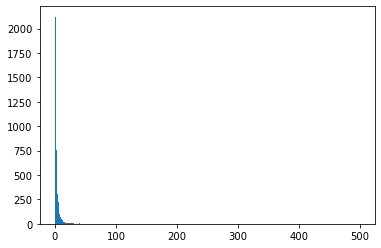

In [31]:
fig, ax = plt.subplots()
ax.hist(movie_budgets_posGross['worldwide_roi'],bins=500);

In [32]:
# from looking at the histogram, it appears the vast majority of films still appear to have ROIs less than 50
# need to more closely examine the films that have ROIs greater than 50
movie_budgets_posGross[movie_budgets_posGross['worldwide_roi'] > 50]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_roi,worldwide_roi
3464,65,"May 25, 1977",Star Wars Ep. IV: A New Hope,11000000,460998007,786598007,41.908910,71.508910
3525,26,"Jun 11, 1982",ET: The Extra-Terrestrial,10500000,435110554,792965326,41.439100,75.520507
4112,13,"Jun 16, 1978",Grease,6000000,181813770,387510179,30.302295,64.585030
4247,48,"Apr 19, 2002",My Big Fat Greek Wedding,5000000,241438208,374890034,48.287642,74.978007
4248,49,"Feb 24, 2017",Get Out,5000000,176040665,255367951,35.208133,51.073590
4249,50,"Jan 20, 2017",Split,5000000,138141585,278964806,27.628317,55.792961
4424,25,"Mar 9, 1994",Four Weddings and a Funeral,4500000,52700832,242895809,11.711296,53.976846
4567,68,"Dec 15, 1939",Gone with the Wind,3900000,198680470,390525192,50.943710,100.134665
4589,90,"Aug 13, 1997",The Full Monty,3500000,45950122,261249383,13.128606,74.642681
4664,65,"Oct 20, 2010",Paranormal Activity 2,3000000,84752907,177512032,28.250969,59.170677


In [10]:
# connect to database and confirm schema for local reference
conn = sqlite3.connect('im.db')
df = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [19]:
movie_basics = pd.read_sql("""
SELECT *
    FROM movie_basics;
""",conn)

In [31]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [35]:
movie_basics[movie_basics['primary_title'] == 'Slacker']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
